## Clustering

Clustering is an unsupervised learning approach used to group similar data points together based on their inherent characteristics. The goal is to identify patterns and structures in the dataset without prior knowledge of the labels. In this project, we hope to use clustering to discover meaningful subgroups within the patient population, which could help in understanding differences in treatment responses or outcomes, and potentially reveal patient phenotypes that benefit from specific interventions.


Table of contents
- 0. Prepare the Jupyter Notebook
- 1. Standardization or Normalization
- 2. Kmeans clustering

### 0. Preparing the Jupyter Notebook

To begin, we load the necessary libraries and import the prepared dataset. We will use **`patient_data_onehot_imputed`** as it already includes all preprocessing steps required for machine learning, except for **normalization or standardization**. This ensures we have a consistent and clean dataset ready for further analysis.


In [1]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer

In [2]:
# Loading the dataset
with open('data/patient_data_onehot_imputed.pkl', 'rb') as file:
    processed_data = pickle.load(file)
    
processed_data.head()

,age,rosc,cpc,hospital_A,hospital_B,hospital_D,hospital_E,hospital_F,sex_Female,sex_Male,ohca_False,ohca_True,ohca_Unknown,ttm_33.0,ttm_36.0,ttm_No TTM,shockable_rhythm_False,shockable_rhythm_True,shockable_rhythm_Unknown
0,53.0,18.0,1,True,False,False,False,False,False,True,False,True,False,True,False,False,False,True,False
1,85.0,7.0,1,False,False,False,False,True,True,False,True,False,False,False,False,True,True,False,False
2,48.0,18.0,1,True,False,False,False,False,False,True,False,True,False,False,True,False,False,True,False
3,45.0,18.0,1,True,False,False,False,False,False,True,False,True,False,True,False,False,False,True,False
4,51.0,24.0,1,False,False,True,False,False,False,True,False,True,False,True,False,False,False,True,False


In [18]:
# Loading the original dataset for later comparison of clusters
with open('data/patient_data.pkl', 'rb') as file:
    original_data = pickle.load(file)
    
original_data.head()

,hospital,age,sex,rosc,ohca,shockable_rhythm,ttm,outcome,cpc,rosc_missing,shockable_rhythm_missing
0,A,53.0,Male,NaN,True,True,33.0,Good,1,1,0
1,F,85.0,Female,7.0,False,False,No TTM,Good,1,0,0
2,A,48.0,Male,NaN,True,True,36.0,Good,1,1,0
3,A,45.0,Male,NaN,True,True,33.0,Good,1,1,0
4,D,51.0,Male,24.0,True,True,33.0,Good,1,0,0


### 1. Standardization or Normalization

Next, we determine whether **standardization** or **normalization** is appropriate for our dataset to ensure consistent feature scaling. To make an informed decision, we first visualize the distribution of the numerical features. Based on these distributions, we then apply the selected scaling technique to align the data for better performance in machine learning models.


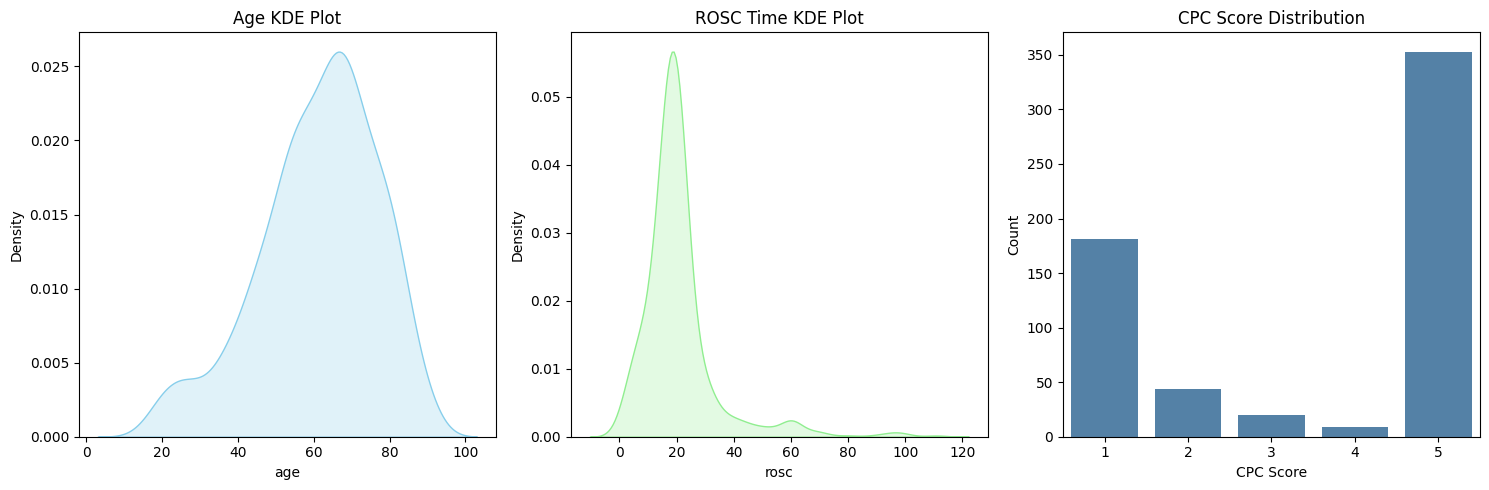

In [3]:
# Plotting count plot for CPC instead of KDE plot
plt.figure(figsize=(15, 5))

# Age KDE Plot
plt.subplot(1, 3, 1)
sns.kdeplot(processed_data['age'], fill=True, color='skyblue')
plt.title('Age KDE Plot')

# ROSC KDE Plot
plt.subplot(1, 3, 2)
sns.kdeplot(processed_data['rosc'], fill=True, color='lightgreen')
plt.title('ROSC Time KDE Plot')
# CPC Count Plot
plt.subplot(1, 3, 3)
sns.countplot(x='cpc', data=processed_data, color='steelblue')
plt.title('CPC Score Distribution')
plt.xlabel('CPC Score')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [4]:
# Display all unique ROSC times from the dataset
unique_rosc_times = processed_data['rosc'].unique()
unique_rosc_times_sorted = np.sort(unique_rosc_times)

# Print the unique ROSC times in sorted order
print(unique_rosc_times_sorted)

[  1.    2.    3.    4.    5.    6.    7.    8.    9.   10.   11.   12.
  13.   14.   15.   16.   17.   18.   19.   20.   21.   21.5  22.   24.
  25.   26.   27.   29.   30.   32.   33.   34.   35.   36.   37.   38.
  40.   42.   44.   45.   47.   50.   52.   54.   55.   60.   62.   63.
  67.   70.   80.   90.   95.   96.   98.  100.  111. ]


**Analysis**: The **age** distribution is approximately **normal**, with a slight skew towards lower values and a peak just below **70**. The **ROSC** distribution also appears roughly **normal**, but contains several significant **outliers** that need to be addressed before proceeding with further analysis. Eventhough **ROSC** appears to have negative values, it actually does not.

In [5]:


# Apply Box-Cox transformation to ROSC time
rosc_transformed_boxcox, lambda_value = boxcox(processed_data['rosc'])

# Adding the transformed ROSC data to the dataframe
processed_data['rosc_boxcox'] = rosc_transformed_boxcox

In [6]:


# Apply Yeo-Johnson transformation to ROSC time
power_transformer = PowerTransformer(method='yeo-johnson')
rosc_transformed = power_transformer.fit_transform(processed_data[['rosc']])

# Adding the transformed ROSC data to the dataframe
processed_data['rosc_yeojohnson'] = rosc_transformed

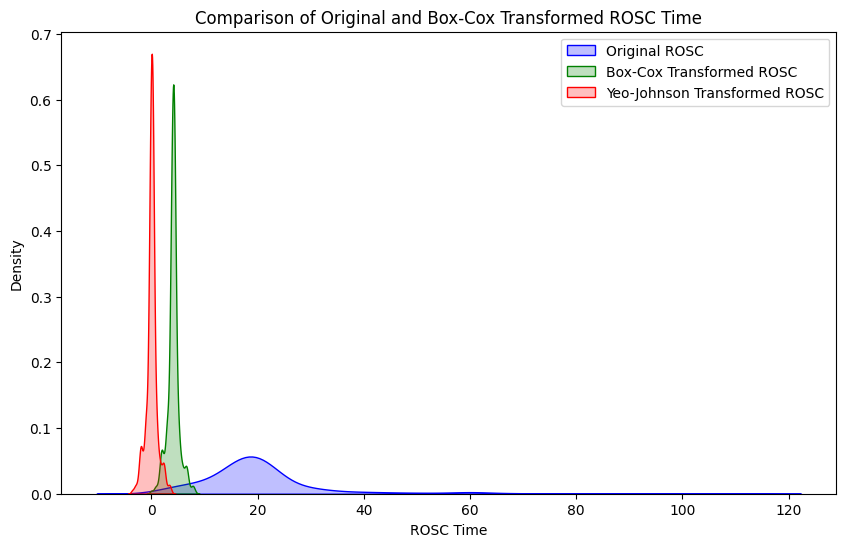

In [7]:
# Plotting original ROSC and Box-Cox transformed ROSC to compare
plt.figure(figsize=(10, 6))

# Original ROSC KDE Plot
sns.kdeplot(processed_data['rosc'], fill=True, color='blue', label='Original ROSC')

# Box-Cox Transformed ROSC KDE Plot
sns.kdeplot(processed_data['rosc_boxcox'], fill=True, color='green', label='Box-Cox Transformed ROSC')

# Apply Yeo-Johnson transformation to ROSC time
sns.kdeplot(processed_data['rosc_yeojohnson'], fill=True, color='red', label='Yeo-Johnson Transformed ROSC')

plt.title('Comparison of Original and Box-Cox Transformed ROSC Time')
plt.xlabel('ROSC Time')
plt.ylabel('Density')
plt.legend()
plt.show()


**Analysis**: Both the **Box-Cox** and **Yeo-Johnson** transformations effectively narrow the distribution, reducing the impact of high outliers. However, the **Box-Cox transformation** retains a slightly broader spread compared to **Yeo-Johnson**, making it preferable for preserving more variability in the data. Therefore, we will proceed with the **Box-Cox transformation**.

#### Standardization
After applying the **Box-Cox transformation** to handle skewness and reduce the influence of outliers, we proceed with **standardization**. Standardization rescales the features so that they have a mean of **0** and a standard deviation of **1**, which is particularly useful for models that assume normally distributed input data or are sensitive to feature scales.

By standardizing the data, we ensure that all features are on a comparable scale, which helps improve model performance and convergence during training.


In [8]:
# Instantiate the scaler
scaler = StandardScaler()

# Columns to standardize
columns_to_standardize = ['age', 'rosc', 'rosc_boxcox', 'rosc_yeojohnson']

# Apply standardization
processed_data[columns_to_standardize] = scaler.fit_transform(processed_data[columns_to_standardize])

# Display the standardized DataFrame
processed_data.head()

,age,rosc,cpc,hospital_A,hospital_B,hospital_D,hospital_E,hospital_F,sex_Female,sex_Male,...,ohca_True,ohca_Unknown,ttm_33.0,ttm_36.0,ttm_No TTM,shockable_rhythm_False,shockable_rhythm_True,shockable_rhythm_Unknown,rosc_boxcox,rosc_yeojohnson
0,-0.522787,-0.215362,1,True,False,False,False,False,False,True,...,True,False,True,False,False,False,True,False,-0.039577,-0.034742
1,1.525272,-1.023892,1,False,False,False,False,True,True,False,...,False,False,False,False,True,True,False,False,-1.510616,-1.537350
2,-0.842797,-0.215362,1,True,False,False,False,False,False,True,...,True,False,False,True,False,False,True,False,-0.039577,-0.034742
3,-1.034802,-0.215362,1,True,False,False,False,False,False,True,...,True,False,True,False,False,False,True,False,-0.039577,-0.034742
4,-0.650791,0.225655,1,False,False,True,False,False,False,True,...,True,False,True,False,False,False,True,False,0.471501,0.482048


#### Selecting Data for the Machine Learning Component from the Original DataFrame

We are now selecting the relevant features, including the transformed `rosc` data, from the original DataFrame. This subset will be placed into a new DataFrame, `machine_learning_df`, for clearer separation and easier manipulation during model training. We can experiment with the included features as needed to optimize model performance.

Based on the findings in **02_Feature_Importance**, we concluded that hospital identifiers are not relevant for our model. This aligns with the medical perspective, as our focus should remain on patient-related features. For now, we will retain the other features and proceed with the Box-Cox transformed `rosc`.

In [9]:
# Selecting the desired columns
selected_columns = ['age', 'cpc', 'sex_Female', 'sex_Male', 'ohca_True', 'ohca_Unknown', 
                    'ttm_33.0', 'ttm_36.0', 'ttm_No TTM', 
                    'shockable_rhythm_False', 'shockable_rhythm_True', 'shockable_rhythm_Unknown', 
                    'rosc_boxcox']

# Creating a new DataFrame with only the selected columns
machine_learning_df = processed_data[selected_columns]

# Rename the 'rosc_boxcox' column to 'rosc'
machine_learning_df = machine_learning_df.rename(columns={'rosc_boxcox': 'rosc'})

# Display the resulting DataFrame
machine_learning_df.head()

,age,cpc,sex_Female,sex_Male,ohca_True,ohca_Unknown,ttm_33.0,ttm_36.0,ttm_No TTM,shockable_rhythm_False,shockable_rhythm_True,shockable_rhythm_Unknown,rosc
0,-0.522787,1,False,True,True,False,True,False,False,False,True,False,-0.039577
1,1.525272,1,True,False,False,False,False,False,True,True,False,False,-1.510616
2,-0.842797,1,False,True,True,False,False,True,False,False,True,False,-0.039577
3,-1.034802,1,False,True,True,False,True,False,False,False,True,False,-0.039577
4,-0.650791,1,False,True,True,False,True,False,False,False,True,False,0.471501


#### Saving Data for Classification Attempts

We are saving `machine_learning_df` to use consistently across classification attempts, ensuring that the same data preparation is applied throughout the model evaluation process.


In [10]:
# Save the DataFrame to a Pickle file
with open('data/machine_learning_patient_data.pkl', 'wb') as f:
    pickle.dump(machine_learning_df, f)

# Confirmation message
print("DataFrame has been saved to 'data/machine_learning_patient_data.pkl'")

DataFrame has been saved to 'data/machine_learning_patient_data.pkl'


### 2. KMeans Clustering
**KMeans Clustering** is an unsupervised machine learning algorithm that groups data points into a specified number of clusters (k) based on feature similarity. The algorithm assigns each data point to the nearest cluster centroid, iteratively updating the centroids until the optimal clustering configuration is reached.

In this project, we use KMeans clustering to uncover potential patterns or natural groupings within the data. By analyzing these clusters, we hope to gain insights into distinct patient subgroups that may share similar characteristics, which could be valuable for tailoring treatment approaches or identifying risk profiles.

#### 2.1 Silhouette Scores

We use **Silhouette Scores** to determine the optimal number of clusters for the `machine_learning_patient_data`. This method evaluates how well each data point fits within its assigned cluster compared to other clusters, providing a measure of clustering quality. Higher silhouette scores indicate that data points are well-matched within their clusters and distinct from others, which helps us assess the "purity" of each cluster.

The algorithm iterates through various cluster counts, calculating the silhouette score for each, allowing us to identify the number of clusters that best separates the data into meaningful groups.


c:\Users\kentf\OneDrive\Studium\M.Sc.Med. Health Informatics\01 Modules\5HI024 - Research\00_Project\Resus_TTM\env_ttm\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\kentf\OneDrive\Studium\M.Sc.Med. Health Informatics\01 Modules\5HI024 - Research\00_Project\Resus_TTM\env_ttm\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


For n_clusters = 2, the average silhouette score is: 0.19217632240061866
For n_clusters = 3, the average silhouette score is: 0.1886552148099906
For n_clusters = 4, the average silhouette score is: 0.2005385436423326
For n_clusters = 5, the average silhouette score is: 0.20881853585806853
For n_clusters = 6, the average silhouette score is: 0.2226159955761607
For n_clusters = 7, the average silhouette score is: 0.24372284182987308
For n_clusters = 8, the average silhouette score is: 0.218862435119304
For n_clusters = 9, the average silhouette score is: 0.21920108588114884
For n_clusters = 10, the average silhouette score is: 0.23720152661351693
For n_clusters = 11, the average silhouette score is: 0.23743945447646417
For n_clusters = 12, the average silhouette score is: 0.23835688877041397
For n_clusters = 13, the average silhouette score is: 0.24194218607126283
For n_clusters = 14, the average silhouette score is: 0.26038922848391444
For n_clusters = 15, the average silhouette score i

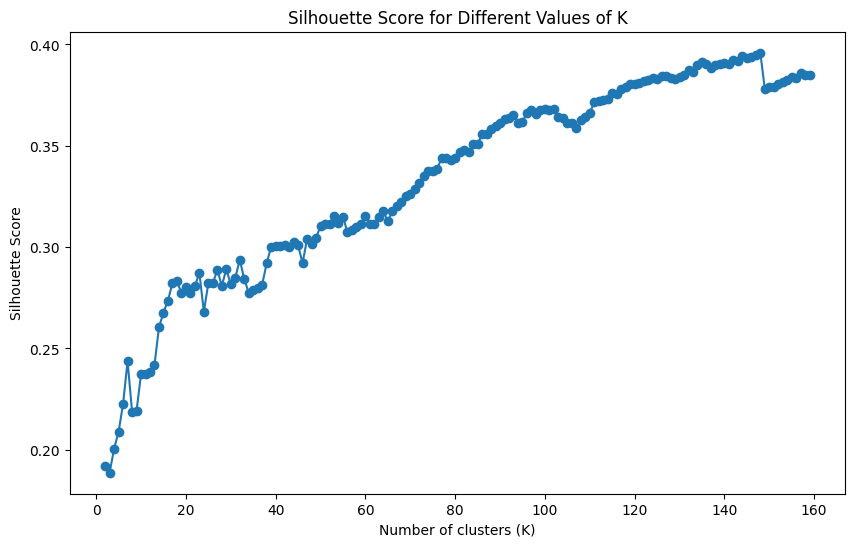

In [11]:
# Exclude the 'cpc' column from the DataFrame
data_for_clustering = machine_learning_df.drop(columns=['cpc'])

# Decide the number of k
# Initialize lists to hold values for plotting
silhouette_scores = []
k_values = range(2, 160)

# Iterate over different values of K
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=2023)
    cluster_labels = kmeans.fit_predict(data_for_clustering)
    silhouette_avg = silhouette_score(data_for_clustering, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {k}, the average silhouette score is: {silhouette_avg}")

# Plot silhouette scores to find the best K
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Values of K')
plt.show()

##### Evaluation of Silhouette Scores for KMeans Clustering

The silhouette scores for different values of \( K \) (number of clusters) are as follows:

- **For \( K = 2 \)**, the average silhouette score is **0.1922**
- **For \( K = 3 \)**, the average silhouette score is **0.1887**
- **For \( K = 4 \)**, the average silhouette score is **0.2005**
- **For \( K = 5 \)**, the average silhouette score is **0.2088**
- **For \( K = 6 \)**, the average silhouette score is **0.2226**
- **For \( K = 7 \)**, the average silhouette score is **0.2437**
- **For \( K = 8 \)**, the average silhouette score is **0.2189**
- **For \( K = 17 \)**, the average silhouette score is **0.2822**
- **For \( K = 18 \)**, the average silhouette score is **0.2830**
- **For \( K = 19 \)**, the average silhouette score is **0.2775**
- **For \( K = 148 \)**, the average silhouette score is **0.3959**

###### Analysis

The silhouette scores indicate that:

- **Usually, there should be only about 10-15% clusters compared to the data size.** Choosing too large a number of clusters can cause overfitting and may even capture noise rather than meaningful patterns. Additionally, for clinical practice, selecting a low number of clusters that remain interpretable is ideal, which typically means fewer than 20 clusters. Although the silhouette score continues to increase and peaks at almost **0.4** with around **150 clusters**, that number is too high, averaging only about 4 points per cluster and likely capturing noise.

- **Considering lower numbers of clusters**, we observe a steady increase in silhouette scores up to \( K = 17 \), where the score reaches **0.2822**. There is a local peak at \( K = 7 \) with a silhouette score of **0.2437**, which may provide a simpler, more interpretable clustering solution.

Based on these scores, we recommend:

1. **For simplicity and interpretability**: Choose **K = 7** clusters. This option provides reasonably good clustering structure with fewer clusters, making it easier to interpret and use for clinical insights.

2. **For more detailed subgroup analysis**: Choose **K = 17** clusters, where the silhouette score is higher, indicating a more granular clustering solution while still maintaining moderate separation.

In summary, **K = 7** and **K = 17** offer the best trade-offs between clustering quality and practical interpretability, avoiding the pitfalls of using an overly large number of clusters. However, the clustering quality is **low**.


In [45]:
# Perform K-means clustering on the standardized data
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, random_state=2023)
kmeans.fit(data_for_clustering)

# Add cluster labels from KMeans to the original data as 'kmeans_cluster'
original_data['kmeans_cluster'] = kmeans.labels_

# Display the first few rows of processed_data with the cluster labels
original_data.head()


,hospital,age,sex,rosc,ohca,shockable_rhythm,ttm,outcome,cpc,rosc_missing,shockable_rhythm_missing,kmeans_cluster
0,A,53.0,Male,NaN,True,True,33.0,Good,1,1,0,0
1,F,85.0,Female,7.0,False,False,No TTM,Good,1,0,0,1
2,A,48.0,Male,NaN,True,True,36.0,Good,1,1,0,0
3,A,45.0,Male,NaN,True,True,33.0,Good,1,1,0,0
4,D,51.0,Male,24.0,True,True,33.0,Good,1,0,0,0


In [46]:
# Count the number of data points in each cluster
cluster_counts = original_data['kmeans_cluster'].value_counts()

# Display the counts for each cluster
print(cluster_counts)

kmeans_cluster
0    162
2    107
3    104
5     96
1     67
4     43
6     28
Name: count, dtype: int64


#### 2.2 Cluster Analysis

We will now analyze the clusters by examining the distribution of features within each cluster. This analysis will provide insights into the characteristics that define each group.


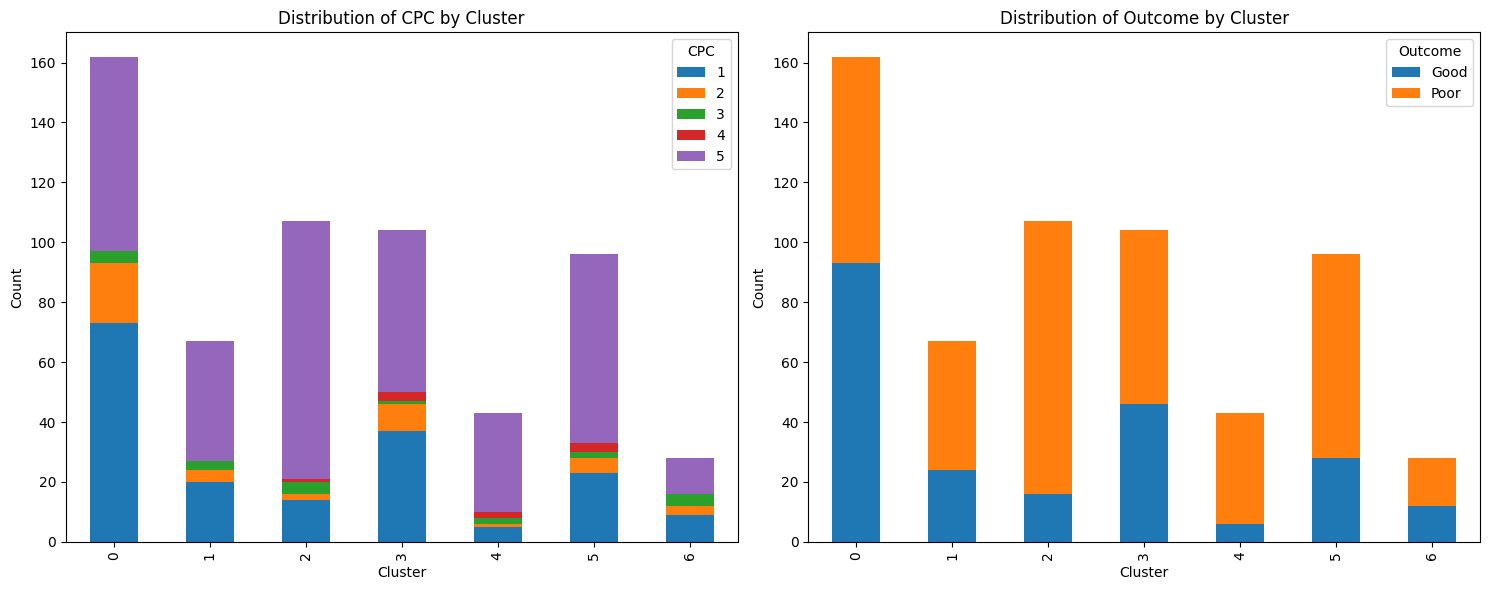

<Figure size 1000x600 with 0 Axes>

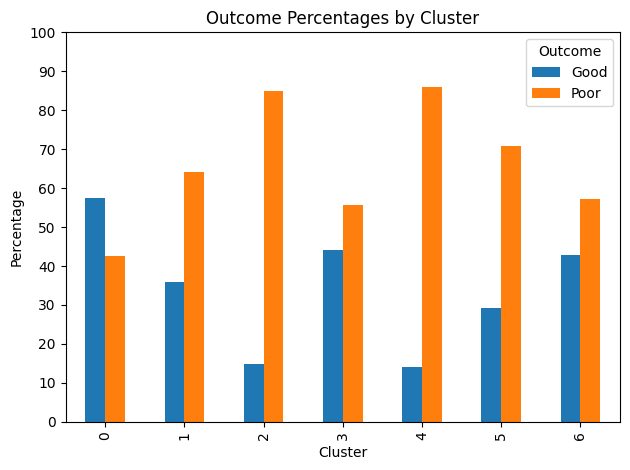

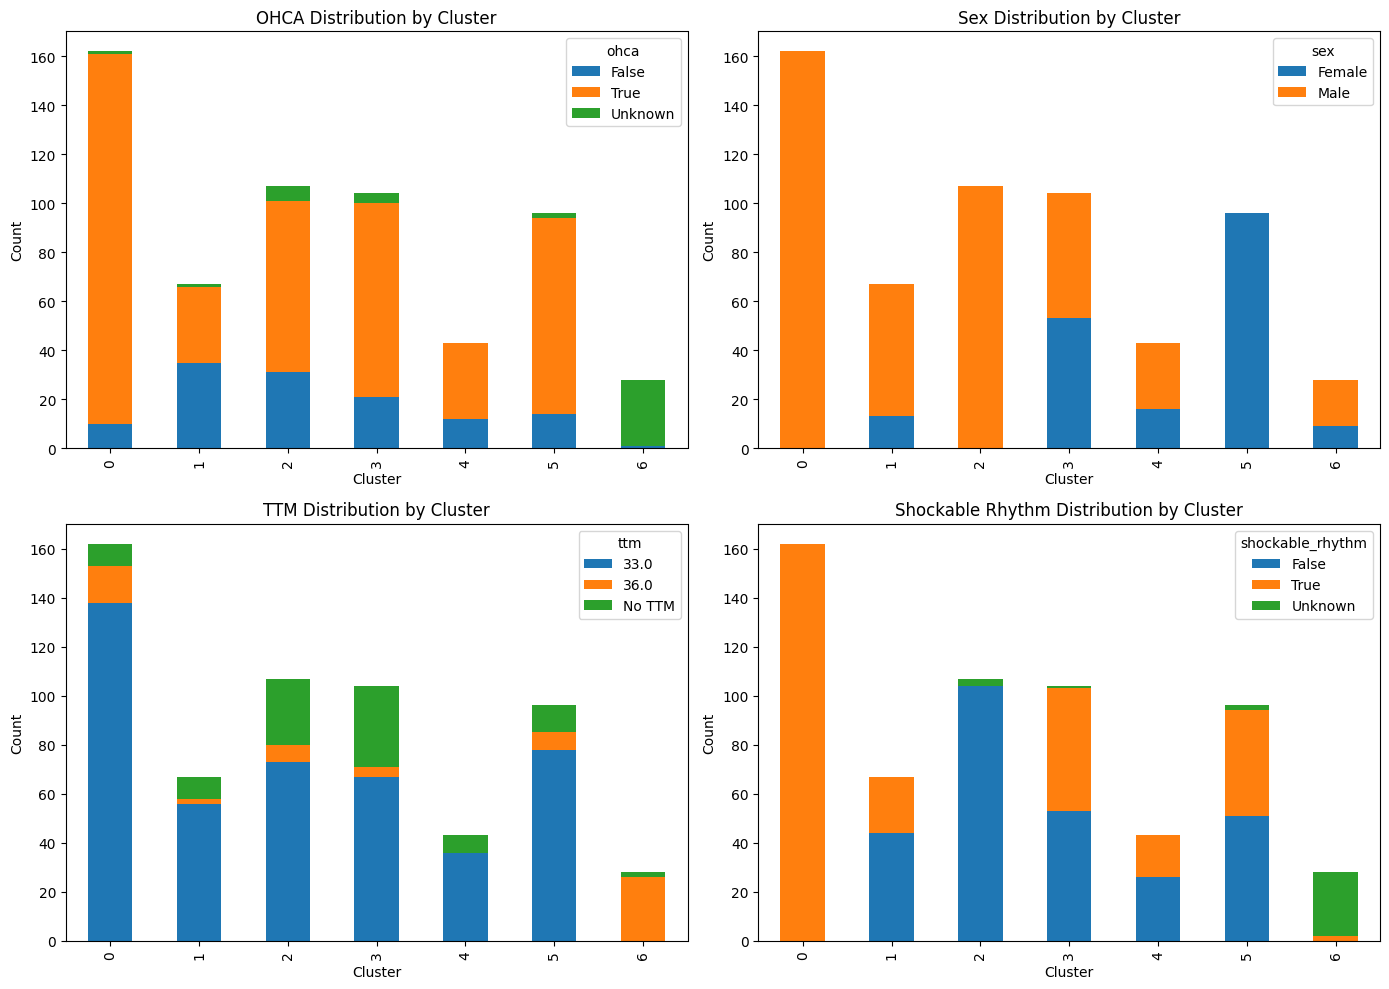

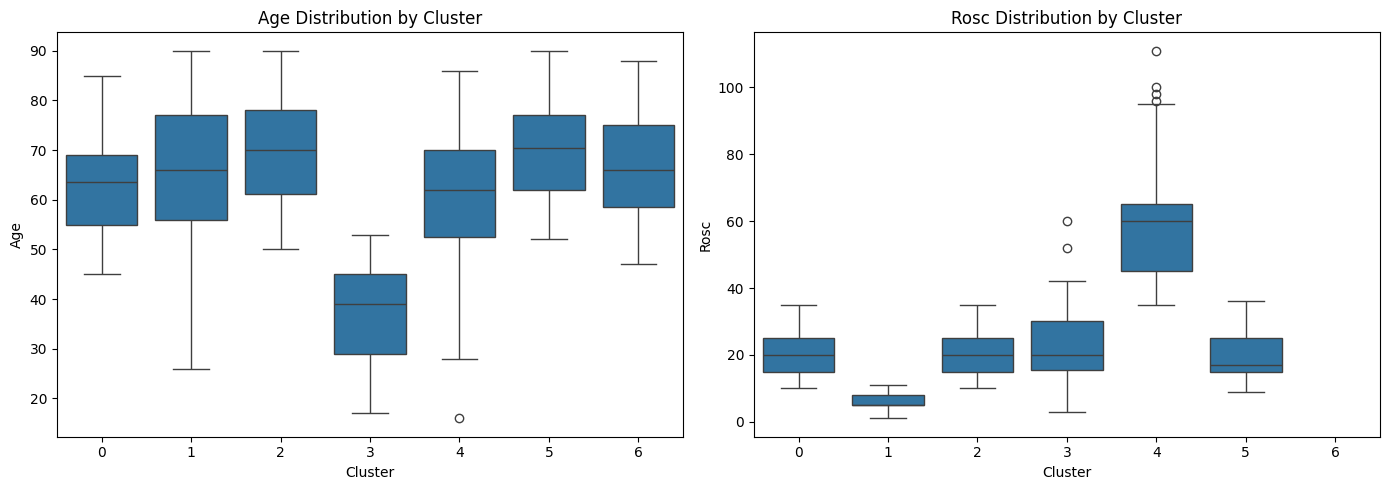

In [47]:
# Start with the distributions of CPC and Outcome
# Count the occurrences of each CPC value for each cluster
cpc_counts = original_data.groupby(['kmeans_cluster', 'cpc'], observed=True).size().unstack(fill_value=0)

# Count the occurrences of each outcome value for each cluster
outcome_counts = original_data.groupby(['kmeans_cluster', 'outcome'], observed=True).size().unstack(fill_value=0)

# Create a figure with 2 subplots for CPC and Outcome distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns

# Create the stacked bar plot for Outcome
outcome_counts.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title('Distribution of Outcome by Cluster')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Count')
axes[1].legend(title='Outcome')

# Create the stacked bar plot for CPC
cpc_counts.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title('Distribution of CPC by Cluster')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Count')
axes[0].legend(title='CPC')

plt.tight_layout()
plt.show()

# Calculate and plot Outcome percentages by cluster
outcome_percentages = outcome_counts.div(outcome_counts.sum(axis=1), axis=0) * 100

# Create a new figure for the Outcome percentages
plt.figure(figsize=(10, 6))
outcome_percentages.plot(kind='bar', stacked=False)

# Add labels and title for Outcome percentages
plt.title('Outcome Percentages by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.legend(title='Outcome')
plt.yticks(range(0, 101, 10))  # Set y-axis from 0 to 100 in steps of 10
plt.tight_layout()
plt.show()

# Define categorical features and their titles for the remaining plots
categorical_features_list = [
    ('ohca', 'OHCA Distribution by Cluster'),
    ('sex', 'Sex Distribution by Cluster'),
    ('ttm', 'TTM Distribution by Cluster'),
    ('shockable_rhythm', 'Shockable Rhythm Distribution by Cluster')
]

# Plot stacked bar charts for each categorical feature
num_features = len(categorical_features_list)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2x2 grid for 4 plots
axes = axes.flatten()  # Flatten for easy iteration

# Loop through each categorical feature and create a stacked bar plot
for ax, (feature, title) in zip(axes, categorical_features_list):
    # Count occurrences for each category in the feature by cluster with observed=True
    feature_counts = original_data.groupby(['kmeans_cluster', feature], observed=True).size().unstack(fill_value=0)
    
    # Plot stacked bar chart
    feature_counts.plot(kind='bar', stacked=True, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Count')
    ax.legend(title=feature, loc='upper right')

plt.tight_layout()
plt.show()

# Box plots for age and rosc distributions by cluster
numeric_features = ['age', 'rosc']
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loop through numeric features and create a box plot for each
for ax, feature in zip(axes, numeric_features):
    sns.boxplot(x='kmeans_cluster', y=feature, data=original_data, ax=ax)
    ax.set_title(f'{feature.capitalize()} Distribution by Cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel(feature.capitalize())

plt.tight_layout()
plt.show()

### Clustering Result Analysis

NEEDS REWORK AFTER CHANGES. 

The focus of this analysis is to identify the characteristics of cardiac arrest patients who can benefit from TTM (targeted temperature management). However, as observed, there is no cluster with significantly better outcomes compared to poor outcomes.

Nonetheless, several notable clusters warrant further analysis:

**Cluster 0**: This cluster has the highest count of good outcomes; however, the difference between good and poor outcomes is only 10%. 
- The characteristics of this cluster include a mean age of 61 years, a mean time to return of spontaneous circulation (ROSC) of 20 minutes, all cases being out-of-hospital cardiac arrests, all patients being male, all receiving TTM at 33°C, and a predominance of shockable rhythms.

**Cluster 2**: This cluster has the highest count of poor outcomes. 
- It features a mean age of 62 years, a mean time to ROSC of 23 minutes, a majority being out-of-hospital cardiac arrests, all patients being male, mostly receiving TTM at 33°C, and a predominance of unshockable rhythms.

**Cluster 4** and **Cluster 7**: These clusters exhibit the greatest percentage difference between good and poor outcomes. 
- Cluster 4 has a mean age of 58 years, a mean time to ROSC of 20 minutes, mostly comprising out-of-hospital cardiac arrests, all patients being female, predominantly receiving TTM at 33°C, and mostly having shockable rhythms. 
- Cluster 7 has a mean age of 48 years, a mean time to ROSC of 26 minutes, primarily consisting of out-of-hospital cardiac arrests, all patients being female, mostly receiving no TTM, and predominantly having shockable rhythms.
- The mean age of these clusters are younger compared to the others

**Cluster 9**: This cluster has a mean age below 60 years (56 years) but predominantly shows poor outcomes.
- The mean time to return of spontaneous circulation (ROSC) is 19 minutes, mostly comprises out-of-hospital cardiac arrests, primarily includes male patients, most patients did not receive targeted temperature management (TTM) and the majority have unshockable rhythms.

### Conclusion
1. Clusters 4 and 7 exhibit the greatest percentage difference between good and poor outcomes (20%), with good outcomes having a higher count, which may be due to a mean age of less than 60.
2. Although Cluster 9 has a mean age of less than 60, it predominantly shows poor outcomes. This difference may be attributed to the patients in Cluster 9 having unshockable rhythms.
3. Examining Clusters 2 and 9, it appears that patients with unshockable rhythms experience poor outcomes, regardless of whether they receive targeted temperature management (TTM) or not.